
Question 1

	Calculated error rates for various values of d and n
╒════╤═════╤═════╤══════════════╕
│    │   n │   d │   error_rate │
╞════╪═════╪═════╪══════════════╡
│  0 │   1 │   1 │        47.17 │
├────┼─────┼─────┼──────────────┤
│  1 │   1 │   2 │        41.51 │
╘════╧═════╧═════╧══════════════╛

	Printing scatter plot of error rates for various values of n and d


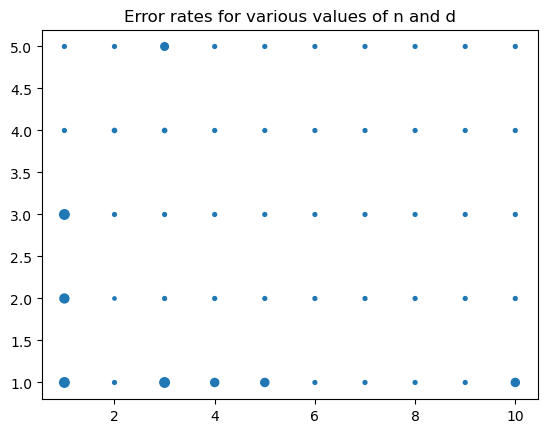


	Values of n and d that correspond to the lowest error rate of 5.66  are 2 2

Question 2
	Confusion Matrix for 2020 stock dataset from RandomForest classifier


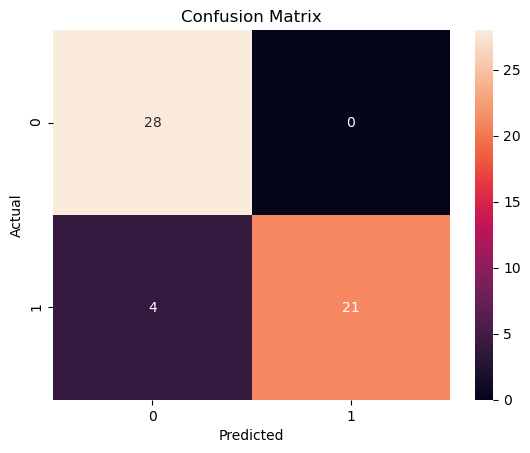


Question 3
	For Random Forest: TPR of 2020 dataset is 100.0 TNR of 2020 dataset is 84.0 


Question 4
	Using predicted labels from LDA classifier, the trading strategy returns = 134.01 .Buy hold returns for the same dataset is 30.95 .The trading strategy gave much higher returns than using buy and hold strategy.


<ipython-input-1-58e89a264d35>:164: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  stock_agg2020_df = stock_agg2020_df.drop('label',1)


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn . ensemble import RandomForestClassifier
from sklearn . preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import matplotlib.pyplot as plt

##set default config
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 12)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:,.2f}'.format

##set filenames
input_dir = os.getcwd()
root_dir = os.getcwd()

labels_file ='BAC_weekly_return_volatility_labels'
details_file = 'BAC_weekly_return_volatility_detailed'
labels_path_file = os.path.join(input_dir, labels_file+'.csv')
details_path_file = os.path.join(input_dir,details_file+'.csv')


try:
   labels_df = pd.read_csv(labels_path_file)
   details_df = pd.read_csv(details_path_file)
except Exception as e:
  print(e)
  print('Failed to read input files', labels_file)


## split dataframe into train and test
stock2019_df = labels_df[labels_df['Year'].isin([2019])]
stock2020_df = labels_df[labels_df['Year'].isin([2020])]

# Question 1 - Run Logistic on training 
X_train = stock2019_df[['mean_return','volatility']]
Y_train = stock2019_df[['label']]
X_test = stock2020_df[['mean_return','volatility']]
Y_test = stock2020_df[['label']]
scaler = StandardScaler ()
scaler .fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

print('\nQuestion 1')
# Apply Random Forest classifier to the split data frame
def calc_randomforest_accuracy(n,d):
    model = RandomForestClassifier ( n_estimators =n, max_depth =d,
criterion ='entropy')
    clf = model.fit(X_train, np.ravel(Y_train))
    RD_pred = clf.predict(X_test)
    accuracy = round(100- (np.mean(RD_pred == np.ravel(Y_test))*100),2)
    return accuracy


est_n=np.arange(1,11)
est_list = list(np.repeat(est_n,5))
depth_n=np.arange(1,6)
depth_list = (list(depth_n)*10)
accuracy = []

for n in est_n:
    for d in depth_n:
        accuracy.append(calc_randomforest_accuracy(n,d))

RF_error_df = pd.DataFrame({'n': est_list, 'd': depth_list, 'error_rate': accuracy})
print("\n\tCalculated error rates for various values of d and n")
print(tabulate(RF_error_df.head(2), headers = "keys",tablefmt = "fancy_grid"))

##plot error rate for n and d
print("\n\tPrinting scatter plot of error rates for various values of n and d")
plt.scatter(RF_error_df['n'],RF_error_df['d'],s=RF_error_df['error_rate'])
plt.title("Error rates for various values of n and d")
plt.show()

best_n = RF_error_df.loc[RF_error_df['error_rate'].idxmin(),'n']
best_d = RF_error_df.loc[RF_error_df['error_rate'].idxmin(),'d']
best_error_rate = RF_error_df['error_rate'].min()
print('\n\tValues of n and d that correspond to the lowest error rate of',best_error_rate,' are', best_n,best_d)


# Question 2 - print confusion matrix using best values
model = RandomForestClassifier ( n_estimators =best_n, max_depth = best_d,
criterion ='entropy')
clf = model.fit(X_train, np.ravel(Y_train))
RD_pred = clf.predict(X_test)
cm=confusion_matrix(np.ravel(Y_test),RD_pred)
cm = pd.DataFrame(cm)
print('\nQuestion 2\n\tConfusion Matrix for 2020 stock dataset from RandomForest classifier')
import seaborn as sns
sns.heatmap(cm, annot=True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Question 3 - calculate tpr and tnr

## for lda
tp = cm[0][0]
tn = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]

tpr = 100*round(tp/(tp+fn),2)
tnr = 100*round(tn/(fp+tn),2)

print('\nQuestion 3\n\tFor Random Forest: TPR of 2020 dataset is',round(tpr,2),'TNR of 2020 dataset is',round(tnr,2),'\n')


# Question 4 calculate returns using predicted labels
pred_stock_df = labels_df.copy().reset_index()
pred_stock_df = details_df.merge(labels_df[['Year','Week_Number','label']], on= ['Year','Week_Number'], how = 'inner')
pred_stock_df = pred_stock_df[['Open','Adj Close','Year','Week_Number',\
            'mean_return','volatility','label']]

## copy Open and Adj Close prices from first and last day of each week
stock_agg_df = pred_stock_df.groupby(['Year','Week_Number']).agg({'Open':'first', 'Adj Close':'last', 'mean_return':'first', 'volatility':'first','label':'first'})

## calculate weekly returns
stock_agg_df['week_return'] = (stock_agg_df['Adj Close'] - stock_agg_df['Open'])/stock_agg_df['Open']

stock_agg_df = stock_agg_df.reset_index()

## split dataframe for year 2020
stock_agg2020_df = stock_agg_df[stock_agg_df['Year'].isin([2020])]

def my_returns(data):
    ## create new col for cumulative returns based on predicted labels
      new_col = 'my_return'
      #data[new_col] = '100'
      previous_day = 100.00
      ## if label = +, then return = Open/principal*(Adj Close) else its prev principal
      ## if label is - then return = prev_day
      for row in data.index:
          if data['label'][row] == '+':
              investment_return = float(previous_day)*(1+float(data['week_return'][row]))
          else:
              investment_return = float(previous_day)
          data.loc[row,new_col] = investment_return 
          previous_day = data[new_col][row]
      data[new_col] = pd.to_numeric(data[new_col],errors = 'coerce')
      return round(investment_return,2)

def buy_hold_return(data):
    ## create new data col
    new_col = 'Buy_Hold'
    ## set default 
    data[new_col] = '100'
    previous_day = 100.00
    ## for each row calculate net_return = prev_day(1+ curr_day return)
    for row in data.index:
        investment_return = float(previous_day)*(1+ float(data['week_return'][row]))
        data.loc[row,new_col] = investment_return 
        previous_day = data[new_col][row]
        data[new_col] = pd.to_numeric(data[new_col],errors = 'coerce')  
    return round(investment_return, 2)    

## attach newly predicted labels
stock_agg2020_df = stock_agg2020_df.drop('label',1)
stock_agg2020_df['label'] = RD_pred
rd_final_returns = my_returns(stock_agg2020_df)
rd_buy_hold_returns = buy_hold_return(stock_agg2020_df)


print('\nQuestion 4\n\tUsing predicted labels from LDA classifier, the trading strategy returns =', rd_final_returns, '.Buy hold returns for the same dataset is', rd_buy_hold_returns,'.The trading strategy gave much higher returns than using buy and hold strategy.' )

